In [41]:
# Dependencies
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mc
from modules.dataset import load_words, load_tweets
from modules.network import get_edges, get_degree, save_edges, map_words

# Set up default colors
colors=[*mc.TABLEAU_COLORS.values()]

%matplotlib inline

# Dataset

## Dataset creation

In [42]:
# Load words dataset table
words = load_words('data/database/words.csv')
words.head()

,tweet,index,text,pos,conf
0,1000007326789758987,7,poor,A,0.9889
1,1000007326789758987,8,area,N,0.9991
2,1000007326789758987,13,find,V,0.9979
3,1000007326789758987,17,community,N,0.9951
4,1000007326789758987,18,provide,V,0.9899


In [43]:
# Retrieve dictionaries mapping lemma tuples to numeric value
w2i, i2w = map_words(words)

In [44]:
# Map lemmas to node numbers
words['node'] = words.apply(lambda w: w2i[(w.text, w.pos)], axis=1)
words.head()

,tweet,index,text,pos,conf,node
0,1000007326789758987,7,poor,A,0.9889,1658
1,1000007326789758987,8,area,N,0.9991,133
2,1000007326789758987,13,find,V,0.9979,873
3,1000007326789758987,17,community,N,0.9951,410
4,1000007326789758987,18,provide,V,0.9899,1754


In [45]:
# Load tweets dataset table
tweets = load_tweets('data/database/tweets.csv')
tweets.head()

,created_at,id_str,text,truncated,geo,coordinates,place,retweet_count,favourite_count,in_reply_to_status_id_str,in_reply_to_user_id_str,lang
0,2018-06-30 22:35:06+00:00,1013189209488797697,"#PrideMonth may be ending today, but we will c...",True,NaN,NaN,NaN,73,NaN,NaN,NaN,en
1,2018-06-30 19:35:07+00:00,1013143915308953606,“This disaster leaves us in extreme poverty......,True,NaN,NaN,NaN,28,NaN,NaN,NaN,en
2,2018-06-30 18:35:07+00:00,1013128815575470081,We want more women on ballots 🗳️ when we go ou...,True,NaN,NaN,NaN,56,NaN,NaN,NaN,en
3,2018-06-30 16:35:09+00:00,1013098625768009728,“The idea that sexism &amp; misogyny in online...,True,NaN,NaN,NaN,107,NaN,NaN,NaN,en
4,2018-06-30 15:05:12+00:00,1013075989885341697,"When women are targeted online, the abuse is m...",True,NaN,NaN,NaN,209,NaN,NaN,NaN,en


## Dataset statistics

### Number of tweets

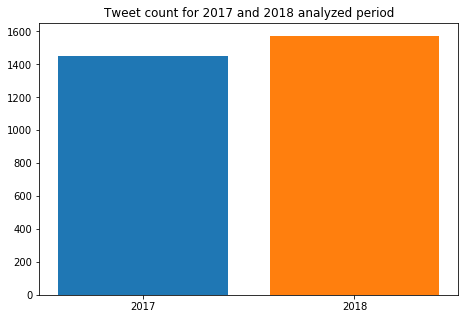

In [46]:
# Define words from tweets of 2017 and the ones from tweets of 2018
tweets_2017 = tweets.id_str[tweets.created_at.dt.year == 2017].values
tweets_2018 = tweets.id_str[tweets.created_at.dt.year == 2018].values

# Show tweets distribution
fig, ax = plt.subplots(figsize=(7.5, 5))
_ = ax.set_title('Tweet count for 2017 and 2018 analyzed period')
_ = ax.bar(['2017'], [len(tweets_2017)])
_ = ax.bar(['2018'], [len(tweets_2018)])
_ = plt.show()

### Words count

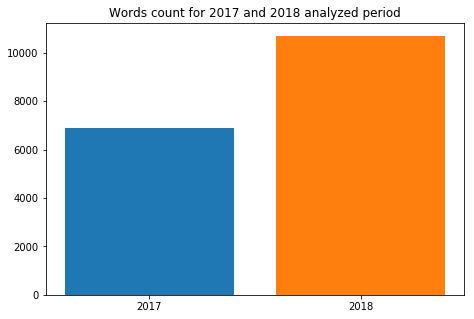

In [47]:
# Show word counts in tweets of 2017 and 2018 respectively
fig, ax = plt.subplots(figsize=(7.5, 5))
_ = ax.set_title('Words count for 2017 and 2018 analyzed period')
_ = ax.bar(['2017'], sum(words.tweet.isin(tweets_2017)))
_ = ax.bar(['2018'], sum(words.tweet.isin(tweets_2018)))
_ = plt.show()

### Unique words count

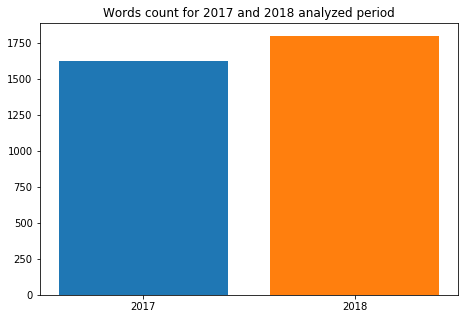

In [48]:
# Show unique word counts in tweets of 2017 and 2018 respectively

unique_words_2017 = words.text[words.tweet.isin(tweets_2017)].unique()
unique_words_2018 = words.text[words.tweet.isin(tweets_2018)].unique()

fig, ax = plt.subplots(figsize=(7.5, 5))
_ = ax.set_title('Words count for 2017 and 2018 analyzed period')
_ = ax.bar(['2017'], unique_words_2017.shape[0])
_ = ax.bar(['2018'], unique_words_2018.shape[0])
_ = plt.show()

### Tweets lengths distributions

Histogram shows the distribution of tweet lengths in either 2017's and 2018'2 network. The difference in the two distributions is due to the fact that in november 2017 the allowed tweet lengths in term of characters has been duplicated by Twitter itself.

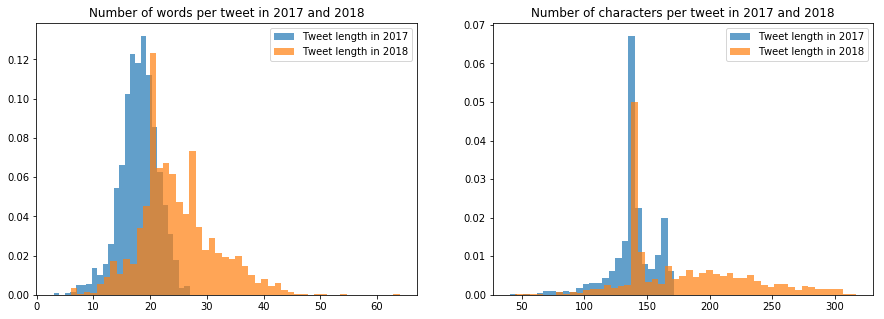

In [49]:
# Compute length of each tweet, for either words and characters
tweets_ = tweets.loc[:, ['id_str']]
tweets_['len_words'] = tweets.apply(lambda t: len(t.text.split(' ')), axis=1)
tweets_['len_chars'] = tweets.apply(lambda t: len(t.text), axis=1)

# Get 2017 and 2018 tweets
tweets_2017_ = tweets_[tweets_['id_str'].isin(tweets_2017)]
tweets_2018_ = tweets_[tweets_['id_str'].isin(tweets_2018)]

# Show distribution of words number per tweet in 2017 and 2018
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Word lengths
_ = axs[0].set_title('Number of words per tweet in 2017 and 2018')
_ = axs[0].hist(tweets_2017_['len_words'], bins=25, density=True, alpha=.7)
_ = axs[0].hist(tweets_2018_['len_words'], bins=50, density=True, alpha=.7)
_ = axs[0].legend(['Tweet length in 2017', 'Tweet length in 2018'])
# Charactes lengths
_ = axs[1].set_title('Number of characters per tweet in 2017 and 2018')
_ = axs[1].hist(tweets_2017_['len_chars'], bins=25, density=True, alpha=.7)
_ = axs[1].hist(tweets_2018_['len_chars'], bins=50, density=True, alpha=.7)
_ = axs[1].legend(['Tweet length in 2017', 'Tweet length in 2018'])
# Make plot
_ = plt.show()

# Network creation

## Edges creation

In [50]:
# Define years under examination
years = [2017, 2018]

In [51]:
# Define edges for 2017 and 2018 (as Pandas DataFrames)
edges = dict()
# Define edges for each network
for y in years:
    # Get id of tweets for current year
    tweet_ids = tweets.id_str[tweets.created_at.dt.year == y]
    # Compute edges for current year
    edges[y] = get_edges(words[words.tweet.isin(tweet_ids)])

In [52]:
# Save all to disk

# Save vocabularies
np.save('data/edges_w2i.npy', w2i)  # Save tuple to index vocabulary
np.save('data/edges_i2w.npy', i2w)  # Save index to tuple vocabulary

# Save edges to disk each edge list
for y in years:
    edges[y].to_csv('data/database/edges_{:d}.csv'.format(y), index=False)

In [53]:
print('Edges for 2017\'s network')
edges[2017].head()

Edges for 2017's network


,node_x,node_y,counts
0,0,654,1
1,0,2466,1
2,0,2469,1
3,4,210,1
4,4,1076,1


In [54]:
print('Edges for 2018\'s network')
edges[2018].head()

Edges for 2018's network


,node_x,node_y,counts
0,1,227,1
1,1,323,1
2,1,772,1
3,1,1000,1
4,1,1429,1


## Adjacency matrices

Compute upper triangular adjacency matrices for either 2017's and 2018's networks. 

Note: adjacency matrices are saved by default to avoid recomputing.

In [55]:
# Define networks container
network = dict()
# Create newtorks
for y in years:
    network[y] = nx.from_pandas_edgelist(edges[y], source='node_x', target='node_y', 
                                         edge_attr='counts', create_using=nx.Graph)

In [56]:
# Get numpy adjacency matrices
adj_matrix = dict()
for y in years:
    adj_matrix[y] = nx.to_numpy_matrix(network[y], weight='counts')

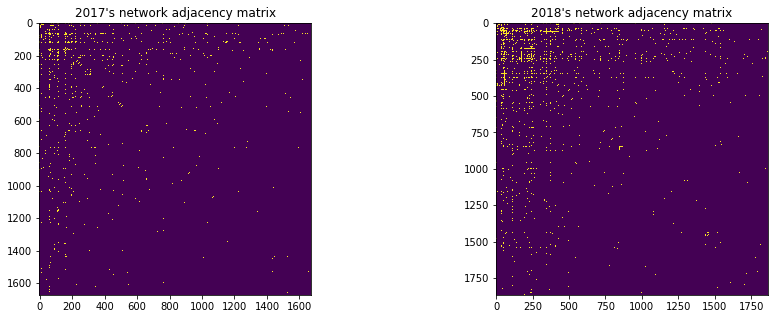

In [57]:
# Show adjacency matrices
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Print adjacency matrix for each network
for i, y in enumerate(years):
    _ = axs[i].set_title('{:d}\'s network adjacency matrix'.format(y))
    _ = axs[i].imshow(np.minimum(adj_matrix[y], np.ones(adj_matrix[y].shape)))
_ = plt.show()

## Summary statistics

Compute mean, density, and other summary statistics for both 2017's and 2018's networks

In [58]:
# Initialize summary statistics
mean = {}
density = {}

# Compute mean and density
for y in years:
    x = adj_matrix[y]  # Get adjacency matrix for current network
    n = x.shape[0]  # Get dimension of the adjacency matrix
    mean[y] = x.sum().sum() / (n * (n - 1))
    density[y] = np.minimum(x, np.ones((n, n))).sum().sum() / (n * (n - 1))

# Print out results
for y in years:
    print('{:d}\'s network has mean={:.04f} and density={:.04f}'.format(y, mean[y], density[y]))

2017's network has mean=0.0113 and density=0.0090
2018's network has mean=0.0223 and density=0.0147


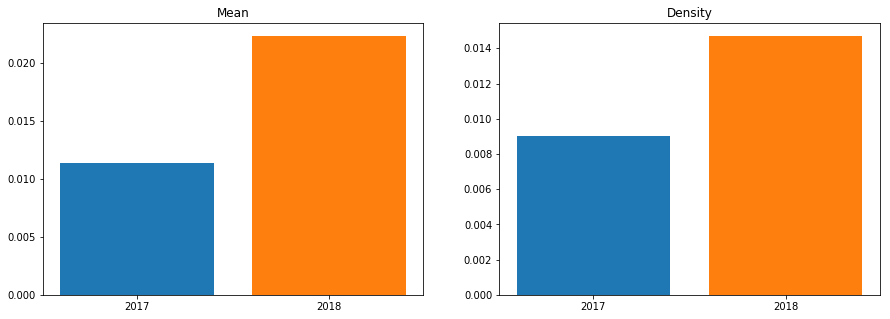

In [59]:
# Show summary statistics graphically
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
_ = axs[0].set_title('Mean')
_ = axs[1].set_title('Density')
# Print scores for either 2017 and 2018
for y in years:
    _ = axs[0].bar(str(y), mean[y])
    _ = axs[1].bar(str(y), density[y])
# Make plot
_ = plt.show()

## Degrees analysis

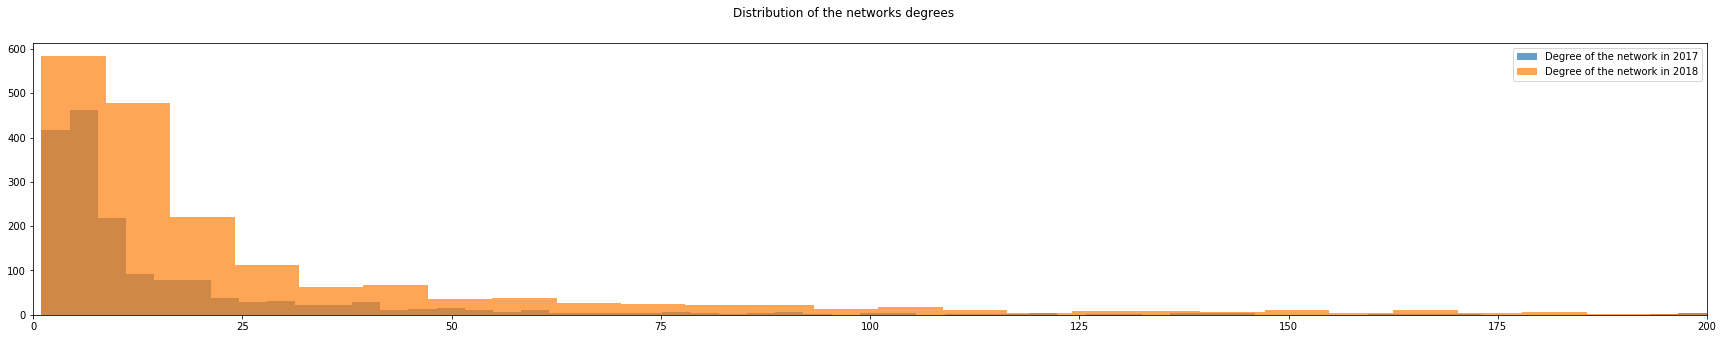

In [60]:
# Compare degrees graphically
fig, ax = plt.subplots(figsize=(30, 5))
_ = fig.suptitle('Distribution of the networks degrees')
_ = ax.hist(get_degree(network[2017]), bins=500, alpha=0.7)
_ = ax.hist(get_degree(network[2018]), bins=500, alpha=0.7)
_ = ax.set_xlim(0, 200)
_ = ax.legend(['Degree of the network in 2017',
               'Degree of the network in 2018'])
_ = plt.show()

In [61]:
# Define function for computing degree analysis (compute pdf, cdf, ...)
def make_degree_analysis(network):
    """
    Input:
    - degrees Pandas Series node (index) maps to its degree (value)
    Output:
    - degree: list of degrees
    - counts: list containing count for each degree 
    - pdf (probability distribution function): list
    - cdf (cumulative distribution function): list
    """
    # Get number of times a degree appeared in the network
    degree = get_degree(network)
    degree, count = np.unique(degree.values, return_counts=True)
    pdf = count / np.sum(count)  # Compute pdf
    cdf = list(1 - np.cumsum(pdf))[:-1] + [0]  # Compute cdf
    # Return computed statistics
    return degree, count, pdf, cdf

In [62]:
# Define function for plotting degree analysis
def plot_degree_analysis(network):
    
    # Initialize plot
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    _ = axs[0].set_title('Probability Distribution Function')
    _ = axs[1].set_title('Log-log Probability Distribution Function')
    _ = axs[2].set_title('Log-log Cumulative Distribution Function')
    
    # Create plot fore each network
    for i, y in enumerate(network.keys()):
        # Compute degree statistics
        k, count, pdf, cdf = make_degree_analysis(network[y])
        # Make plots
        _ = axs[0].plot(k, pdf, 'o', alpha=.7)
        _ = axs[1].loglog(k, pdf, 'o', alpha=.7)
        _ = axs[2].loglog(k, cdf, 'o', alpha=.7)

    # Show plots
    _ = [axs[i].legend([str(y) for y in network.keys()], loc='upper right') for i in range(3)]
    _ = plt.show()

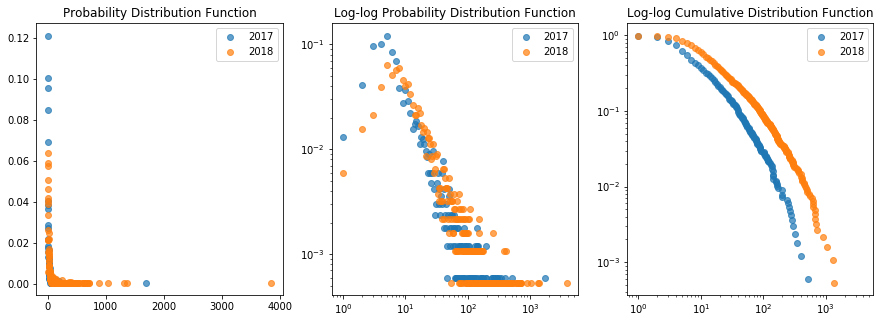

In [63]:
# Plot pdf, cdf, log-log, ... of each network
plot_degree_analysis(network)

# Scale-free property

## Power law estimation

In [64]:
# Estimate power law parameters for each network

# Initialize power law parameters
power_law = {
    2017: {'k_sat': 4},
    2018: {'k_sat': 7}
}

# Define parameters for each network
for i, y in enumerate(years):
    # Get the unique values of degree and their counts
    degree = get_degree(network[y])
    k, count = np.unique(degree, return_counts=True)
    k_sat = power_law[y]['k_sat']
    # Define minumum and maximum k (degree)
    power_law[y]['k_min'] = k_min = np.min(k)
    power_law[y]['k_max'] = k_max = np.max(k)
    # Estimate parameters
    n = degree[k_sat:].shape[0]
    gamma = 1 + n / np.sum(np.log(degree[k_sat:] / k_sat))
    c = (gamma - 1) * k_sat ** (gamma - 1)
    # Compute cutoff
    cutoff = k_sat * n ** (1 / (gamma - 1))
    # Store parameters
    power_law[y]['gamma'] = gamma
    power_law[y]['c'] = c
    power_law[y]['cutoff'] = cutoff

In [65]:
# Pront out coefficients
for y in power_law.keys():
    # Retrieve parameters
    gamma, c, cutoff = power_law[y]['gamma'], power_law[y]['c'], power_law[y]['cutoff']
    k_min, k_max = power_law[y]['k_min'], power_law[y]['k_max']
    # Print results
    out = 'Power law estimated parameters for {:d}\'s network:\n'
    out += '  gamma={:.03f}, c={:.03f}, cutoff={:.03f}, min.degree={:d}, max.degree={:d}'
    print(out.format(y, gamma, c, cutoff, k_min, k_max))

Power law estimated parameters for 2017's network:
  gamma=2.216, c=6.555, cutoff=1791.365, min.degree=1, max.degree=1687
Power law estimated parameters for 2018's network:
  gamma=2.144, c=10.610, cutoff=5031.222, min.degree=1, max.degree=3847


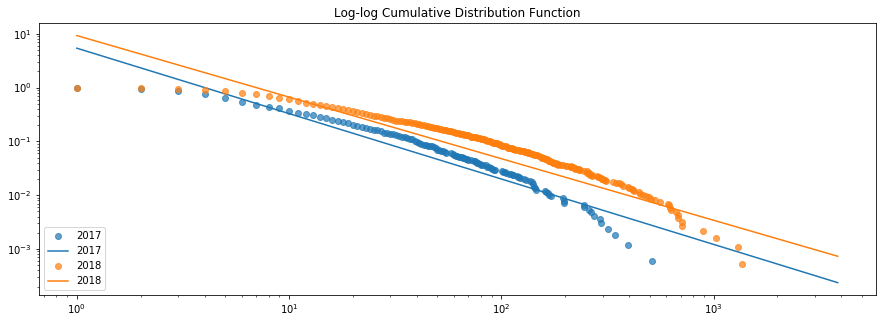

In [66]:
# Define regression lines values for either 2017 and 2018 distributions

# Define regression lines container
regression_line = {}
# Define maximum degree, for both years together
k_max = np.max([power_law[y]['k_max'] for y in power_law.keys()])
# Compute regression lines
for y in power_law.keys():
    # Retrieve parameters gamma and c
    gamma = power_law[y]['gamma']
    c = power_law[y]['c']
    # Compute regression line
    regression_line[y] = c * np.arange(1, k_max) ** (1 - gamma) / (gamma - 1)

# Plot results
fig, ax = plt.subplots(figsize=(15, 5))
_ = ax.set_title('Log-log Cumulative Distribution Function')
# Print  every network
for i, y in enumerate(power_law.keys()):
    # Retrieve degree analysis values
    k, count, pdf, cdf = make_degree_analysis(network[y])
    # Print dots
    _ = ax.loglog(k, cdf, 'o', alpha=.7, color=colors[i])
    # Print regression line
    _ = ax.loglog(np.arange(1, k_max), regression_line[y], color=colors[i])
# Make plot
_ = ax.legend(['2017']*2 + ['2018']*2, loc='lower left')
# _ = ax.grid()
_ = plt.show()

# Small-world property

## Connected components

In [ ]:
# Extract cardinality of connected components and diameter of the giant component for both nets

"""# Initialize components container
connected_components = {}

# Compute giant component for every network
for i, y in enumerate(network.keys()):
    # Compute connected component
    cc = sorted(nx.connected_components(network[y]), key=len, reverse=True)        
    # Compute diameter of the giant component
    d = nx.diameter(network[y].subgraph(cc[0]))
    # Store the tuple (giant component, cardinality, diameter)
    connected_components[y] = []
    connected_components[y].append({
        'component': cc[0],
        'size': len(cc[0]),
        'diameter': d
    })
    # Store each component
    for component in cc[1:]:
        # Add component, without diameter
        connected_components[y].append({
            'component': component,
            'size': len(component)
        })

# Save connected components to disk
np.save('data/connected_components.npy', connected_components)"""

In [ ]:
# Load connected components from file
connected_components = np.load('data/connected_components.npy', allow_pickle=True).item()

# Show connected components info for each year
for y in years:
    # Retrieve connected component
    cc = connected_components[y]
    # Show giant component info
    print('Network {:d}'.format(y))
    print('Giant component has cardinality={:d} and diameter={:d}'.format(cc[0]['size'], cc[0]['diameter']))
    # Store each component
    for j, component in enumerate(cc):
          if j == 0: continue
          # Show other components
          print('Connected component nr {:d} has cardinality={:d}'.format(j + 1, component['size']))
    print()

## Clustering coefficient

In [ ]:
# Compute and show chlustering coefficients

# Compute clustering coefficients
clust_coef = {y: pd.Series(nx.clustering(network[y],weight='counts')) for y in years}

# Make plot
fig, axs = plt.subplots(1, 2, figsize=(15, 8), sharey=True)
# Loop through each network
for i, y in enumerate(years):
    cc = clust_coef[y]
    _ = axs[i].set_title('{:d}\'s network'.format(y))
    _ = axs[i].plot(cc.index.values, cc.values, 'x', mec=colors[i])
    _ = axs[i].grid()
# Show plot
_ = plt.show()

In [ ]:
giant = {y: connected_components[y][0]['component'] for y in years}

# Compute the average shortest path length for both nets
L = {y: nx.average_shortest_path_length(network[y].subgraph(giant[y]), weight='counts', method='floyd-warshall-numpy') for y in years}

In [ ]:
for y in years:
    print('Network {:d}'.format(y))
    N = len(network[y].nodes)
    print('log N: {:.4f}'.format( np.log(N) ))
    print('log log N: {:.4f}'.format( np.log( np.log(N) ) ))
    print('Average shortest path length: {:.4f}'.format(L[y]))
    print('Average clustering coefficient: {:.4f}'.format(np.mean(clust_coef[y])))
    print()

# Ranking

## Ranking by degree

In [ ]:
# Define subset (firs n-th)
best = 20

# Make plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
# Plot each network
for i, y in enumerate(years):
    degree = get_degree(network[y]).sort_values(ascending=False)
    _ = axs[i].set_title('Best nodes in {:d}\'s network'.format(y))
    _ = axs[i].bar(degree.index[:best].map(lambda x: str(i2w[x])), degree.values[:best])
    _ = axs[i].tick_params(axis='x', labelrotation=60)
# Show plot
_ = plt.show()

## Ranking by betweenness

In [ ]:
"""# Compute betweenness centrality measure for nodes (on giant components)

betweenness = {}

for y in years:
    # Define giant component subgraph
    giant_component = connected_components[y][0]['component']
    subgraph = nx.induced_subgraph(network[y], giant_component)
    # Compute betweenness
    betweenness[y] = nx.betweenness_centrality(subgraph,weight='counts')
    
# Save betweenness as numpy array
np.save('data/betweenness.npy', betweenness)"""

In [ ]:
# Load betweenness
betweenness = np.load('data/betweenness.npy', allow_pickle=True).item()

In [ ]:
# Define subset (firs n-th)
best = 20

# Make plot
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
for i, y in enumerate(years):
    btw = pd.Series(betweenness[y]).sort_values(ascending=False)
    _ = axs[i].set_title('Best nodes in {:d}\'s network'.format(y))
    _ = axs[i].bar(btw.index[:best].map(lambda x: str(i2w[x])), btw.values[:best])
    _ = axs[i].tick_params(axis='x', labelrotation=60)
_ = plt.show()

## Differencen between node sets

In [158]:
x = len(set(network[2017].nodes) - set(network[2018].nodes))/len(set(network[2017].nodes)) * 100
print('Percentage of words in 2017 but not in 2018: {:d} %'.format(int(x)))

Percentage of words in 2017 but not in 2018: 36 %


In [159]:
x =  len(set(network[2018].nodes) - set(network[2017].nodes)) / len(set(network[2018])) * 100
print('Percentage of words in 2018 but not in 2017: {:d} %'.format(int(x)))

Percentage of words in 2018 but not in 2017: 43 %


# Assortativity

In [ ]:
# Set pos-tag and text as attribute of each node

# relation index - pos
i2p = pd.DataFrame(i2w.values()).iloc[:,1]

# add the pos attribute 
for y in years:
    indices = list(network[y].nodes)
    tags = [i2p[i] for i in indices]
    attr_pos = { node: tag for node, tag in tuple(zip(indices, tags)) }
    nx.set_node_attributes(network[y], attr_pos, 'pos')

### Degree assortativity

In [ ]:
print('Assortativity coefficient 2017:',nx.degree_assortativity_coefficient( network[2017], weight = 'counts' ))
print('Assortativity coefficient 2018:',nx.degree_assortativity_coefficient( network[2018], weight = 'counts' ))

### Node assortativity by attribute

In [ ]:
verbs = { y : [x for x,y in network[y].nodes(data='pos') if y == 'V']  for y in years} 

print('Assortativity coefficient 2017:',nx.degree_assortativity_coefficient( network[2017].subgraph(verbs[2017]), weight = 'counts' ))
print('Assortativity coefficient 2018:',nx.degree_assortativity_coefficient( network[2018].subgraph(verbs[2018]), weight = 'counts' ))